## Fable Run through
source:  
https://www.mitchelloharawild.com/blog/fable/

fabletools
Depending on the chosen model, the following features are supported:

* Forecasting (```forecast()```)
* Missing value interpolation (```interpolate()```)
* Reporting model output (```report()```)
* Simulation of future paths (```generate()```)
* Streaming new data (```stream()```)
* Re-estimation (```refit()```)
* Decomposition of model components (```components()```)
* Model equation output (``````equation()``````)
* Broom verbs (```augment()```, ```coef()```/```tidy()```, ```glance()```)
* Model fits (```fitted()```, ```residuals()```)

General fabletools functionality for all models include:

* Seamless integration with existing packages in the tidyverse
* Tools for consistent modelling interface design (such as formula parsing)
* Response transformations and back-transformations with bias adjustment
* Batch modelling with parallelisation
* Forecast distributions and intervals
* Visualisation of time series, decompositions, and forecasts (```autoplot()```)
* Accuracy evaluation (```accuracy()```) with many accuracy measures
* Model combination (```combination_model()``` / ```(ets + arima)/2```)
* Decomposition modelling (```decomposition_model()```)
* Forecast reconciliation (```reconcile()```, ```min_trace()```)

### EDA

In [13]:
suppressPackageStartupMessages(library(fable))
suppressPackageStartupMessages(library(tsibble))
suppressPackageStartupMessages(library(tidyverse))
options(repr.plot.width = 15, repr.plot.height = 8)
add_theme <- function(g){
    return(g+theme_grey(base_size = 22))
}

In [8]:
tourism %>%
    head()

Quarter Region   State           Purpose  Trips   
1 1998 Q1 Adelaide South Australia Business 135.0777
2 1998 Q2 Adelaide South Australia Business 109.9873
3 1998 Q3 Adelaide South Australia Business 166.0347
4 1998 Q4 Adelaide South Australia Business 127.1605
5 1999 Q1 Adelaide South Australia Business 137.4485
6 1999 Q2 Adelaide South Australia Business 199.9126

In [9]:
tourism %>%
    summary()

    Quarter           Region             State             Purpose         
 Min.   :1998 Q1   Length:24320       Length:24320       Length:24320      
 1st Qu.:2002 Q4   Class :character   Class :character   Class :character  
 Median :2007 Q4   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2007 Q4                                                           
 3rd Qu.:2012 Q4                                                           
 Max.   :2017 Q4                                                           
     Trips        
 Min.   :  0.000  
 1st Qu.:  7.224  
 Median : 28.134  
 Mean   : 70.896  
 3rd Qu.: 78.154  
 Max.   :985.278  

In [11]:
(tourism_aus <- tourism %>% 
  summarise(Trips = sum(Trips))) %>%
    head()

Quarter Trips   
1 1998 Q1 23182.20
2 1998 Q2 20323.38
3 1998 Q3 19826.64
4 1998 Q4 20830.13
5 1999 Q1 22087.35
6 1999 Q2 21458.37

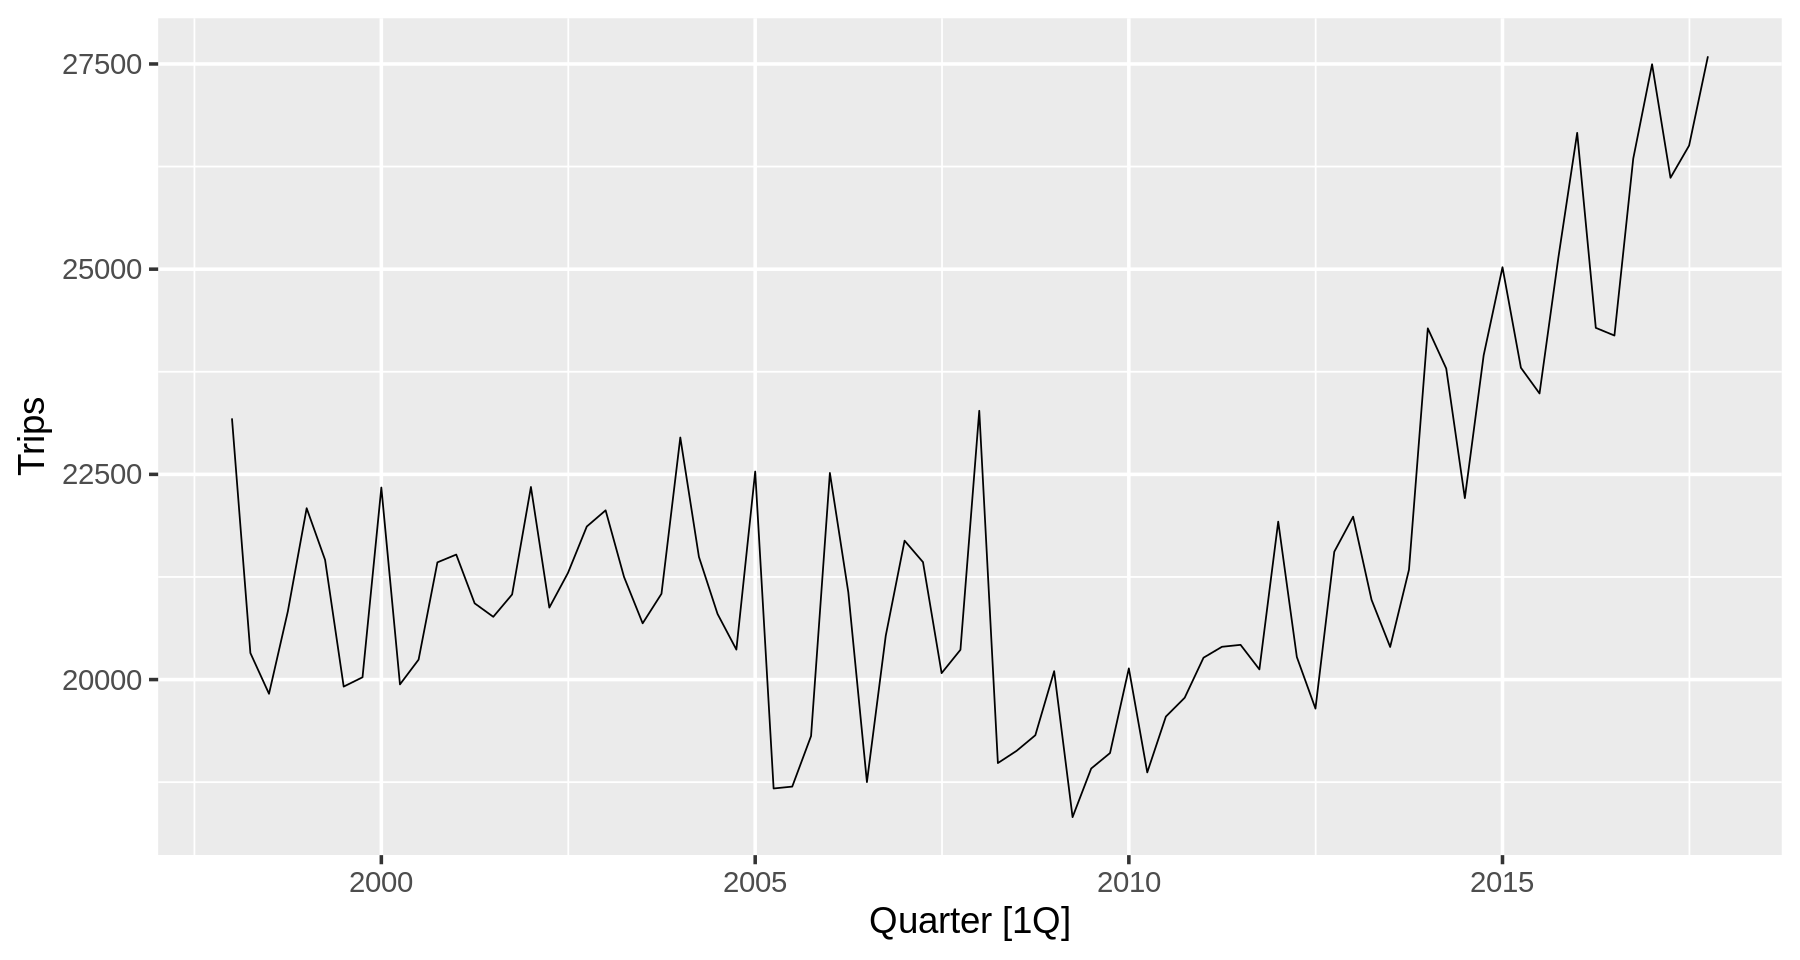

In [30]:
add_theme <- function(g){
    return(g+theme_grey(base_size = 22))
}

tourism_aus %>% 
  autoplot(Trips) %>%
    add_theme()


### Model Of Choice: exponential smoothing model
* Presence of seasonality in data
* Presence of trend in data

R models follows the following format 
```R
```
To specify terms (here model chooses between "A" additive and "M" multiplicative seasonality): 
```R
ETS(Trips ~ error("A") + trend("A") + season(c("A", "M")))
```
By default model chooses among "N" (None), "A" and "M" automatically:
```R
ETS(Trips)
```

In [18]:
(fit <- tourism_aus %>% 
  model(auto_ets = ETS(Trips)))%>%
    print()

# A mable: 1 x 1
  auto_ets    
  <model>     
1 <ETS(A,A,A)>


In [19]:
fit %>%
    report()

Series: Trips 
Model: ETS(A,A,A) 
  Smoothing parameters:
    alpha = 0.4495675 
    beta  = 0.04450178 
    gamma = 0.0001000075 

  Initial states:
        l         b        s1        s2        s3       s4
 21689.64 -58.46946 -125.8548 -816.3416 -324.5553 1266.752

  sigma^2:  699901.4

     AIC     AICc      BIC 
1436.829 1439.400 1458.267 


In [20]:
# tidy() for model coefficients
fit %>%
    tidy()

.model   term  estimate     
1 auto_ets alpha  4.495675e-01
2 auto_ets beta   4.450178e-02
3 auto_ets gamma  1.000075e-04
4 auto_ets l      2.168964e+04
5 auto_ets b     -5.846946e+01
6 auto_ets s0    -1.258548e+02
7 auto_ets s1    -8.163416e+02
8 auto_ets s2    -3.245553e+02

In [21]:
# glance() for model performance
fit %>%
    glance()

.model   sigma2   log_ik    AIC      AICc   BIC      MSE      AMSE    
1 auto_ets 699901.4 -709.4144 1436.829 1439.4 1458.267 629911.3 790553.9
  MAE     
1 604.1089

In [24]:
# augment() enriches model with data and predictions
fit %>%
    augment() %>%
    head()

.model   Quarter Trips    .fitted  .resid     
1 auto_ets 1998 Q1 23182.20 22897.92   284.27888
2 auto_ets 1998 Q2 20323.38 21388.60 -1065.21535
3 auto_ets 1998 Q3 19826.64 20324.70  -498.05995
4 auto_ets 1998 Q4 20830.13 20675.89   154.24129
5 auto_ets 1999 Q1 22087.35 22029.34    58.01106
6 auto_ets 1999 Q2 21458.37 20358.04  1100.33447

In [26]:
# forecast() to predict with h = forecast horizon
(fc <- fit %>% 
  forecast(h = "2 years"))%>%
    print()

# A fable: 8 x 4 [1Q]
# Key:     .model [1]
  .model   Quarter  Trips .distribution    
  <chr>      <qtr>  <dbl> <dist>           
1 auto_ets 2018 Q1 29068. N(29068,  699901)
2 auto_ets 2018 Q2 27794. N(27794,  870750)
3 auto_ets 2018 Q3 27619. N(27619, 1073763)
4 auto_ets 2018 Q4 28627. N(28627, 1311711)
5 auto_ets 2019 Q1 30336. N(30336, 1587455)
6 auto_ets 2019 Q2 29062. N(29062, 1903591)
7 auto_ets 2019 Q3 28887. N(28887, 2262980)
8 auto_ets 2019 Q4 29895. N(29895, 2668392)


In [28]:
# hilo(): Extract forecast intervals
fc %>% 
  hilo(level = c(80, 95)) %>%
    head()

.model   Quarter Trips    80%                                  
1 auto_ets 2018 Q1 29068.10 [27995.95, 30140.25]\03380\033
2 auto_ets 2018 Q2 27793.72 [26597.85, 28989.59]\03380\033
3 auto_ets 2018 Q3 27619.03 [26291.05, 28947.01]\03380\033
4 auto_ets 2018 Q4 28626.52 [27158.76, 30094.28]\03380\033
5 auto_ets 2019 Q1 30336.11 [28721.43, 31950.79]\03380\033
6 auto_ets 2019 Q2 29061.73 [27293.57, 30829.90]\03380\033
  95%                                  
1 [27428.39, 30707.81]\03395\033
2 [25964.80, 29622.64]\03395\033
3 [25588.06, 29649.99]\03395\033
4 [26381.78, 30871.27]\03395\033
5 [27866.67, 32805.55]\03395\033
6 [26357.56, 31765.91]\03395\033

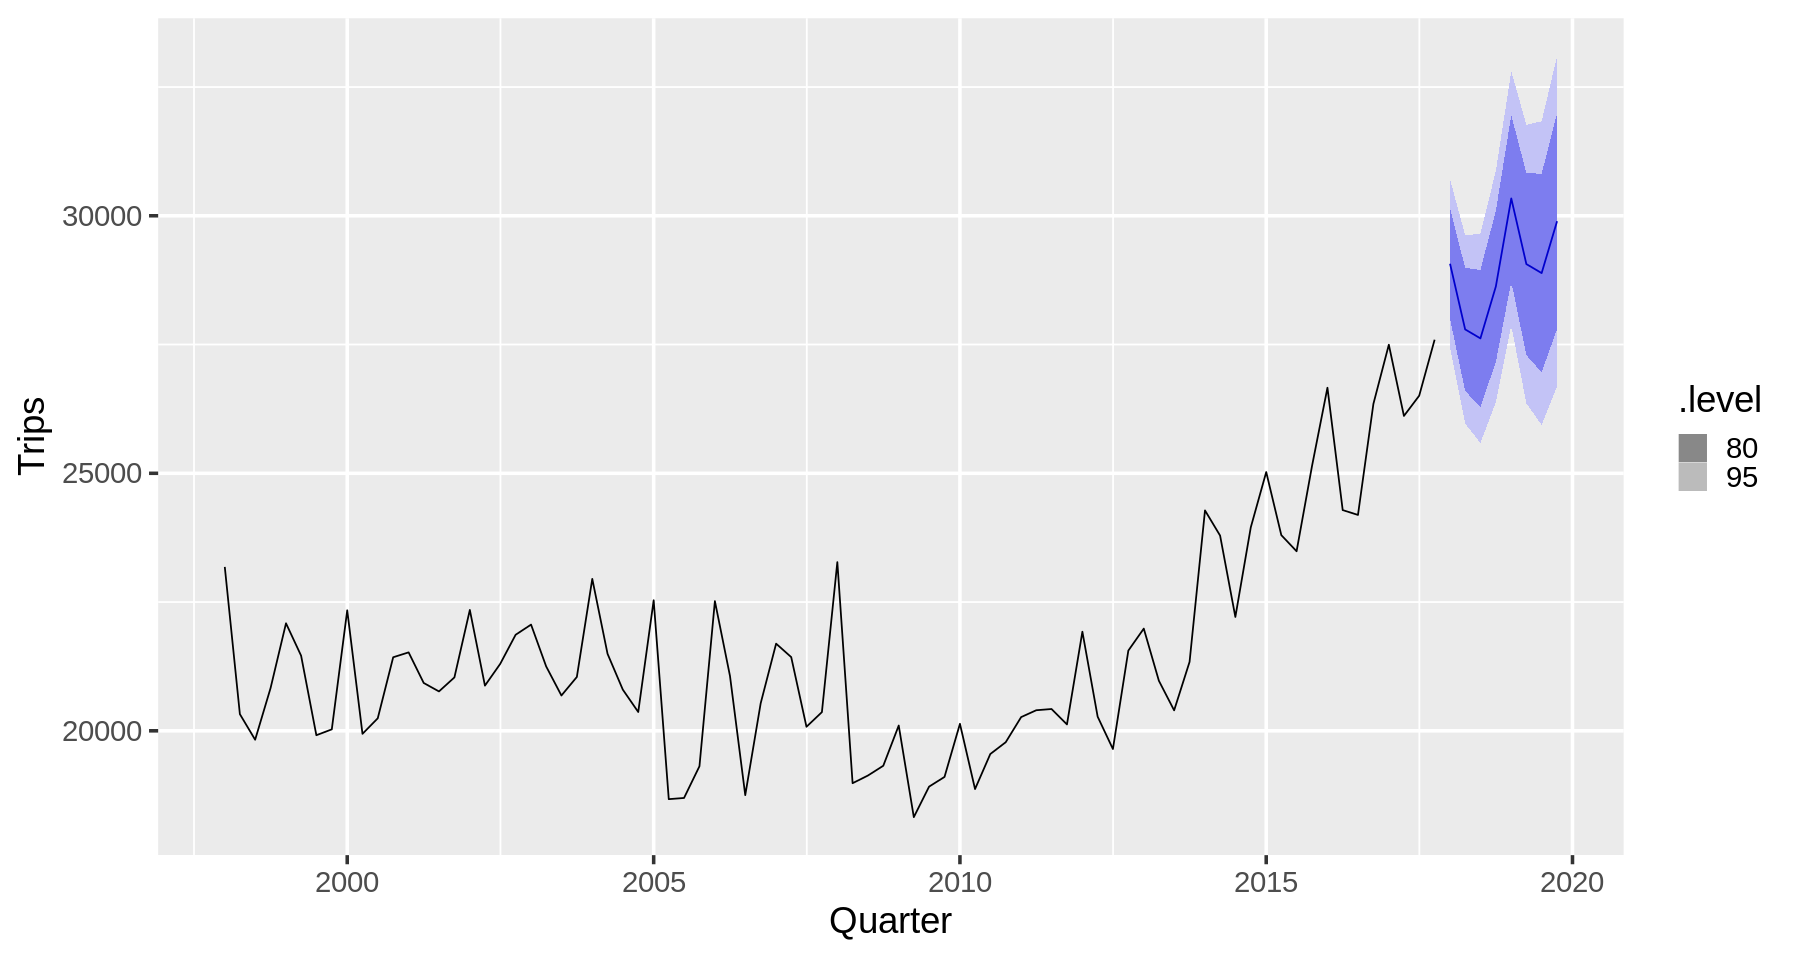

In [32]:
# fable does not store the original data and fitted model in the fable object, 
# so the historical data must be passed in to see it on the plot.
fc %>% 
  autoplot(tourism_aus) %>% # here adding the original data
    add_theme()

### Choosing the best model
```model()``` allows comparison among many models from different model classes. 

In [33]:
(fit <- tourism_aus %>% 
  model(
    ets = ETS(Trips),
    arima = ARIMA(Trips),
    lm = TSLM(Trips ~ trend() + season()) # what does this do? where does trend() and season() come from?
  )) %>%
    print()

# A mable: 1 x 3
  ets          arima                    lm     
  <model>      <model>                  <model>
1 <ETS(A,A,A)> <ARIMA(0,1,1)(0,1,1)[4]> <TSLM> 


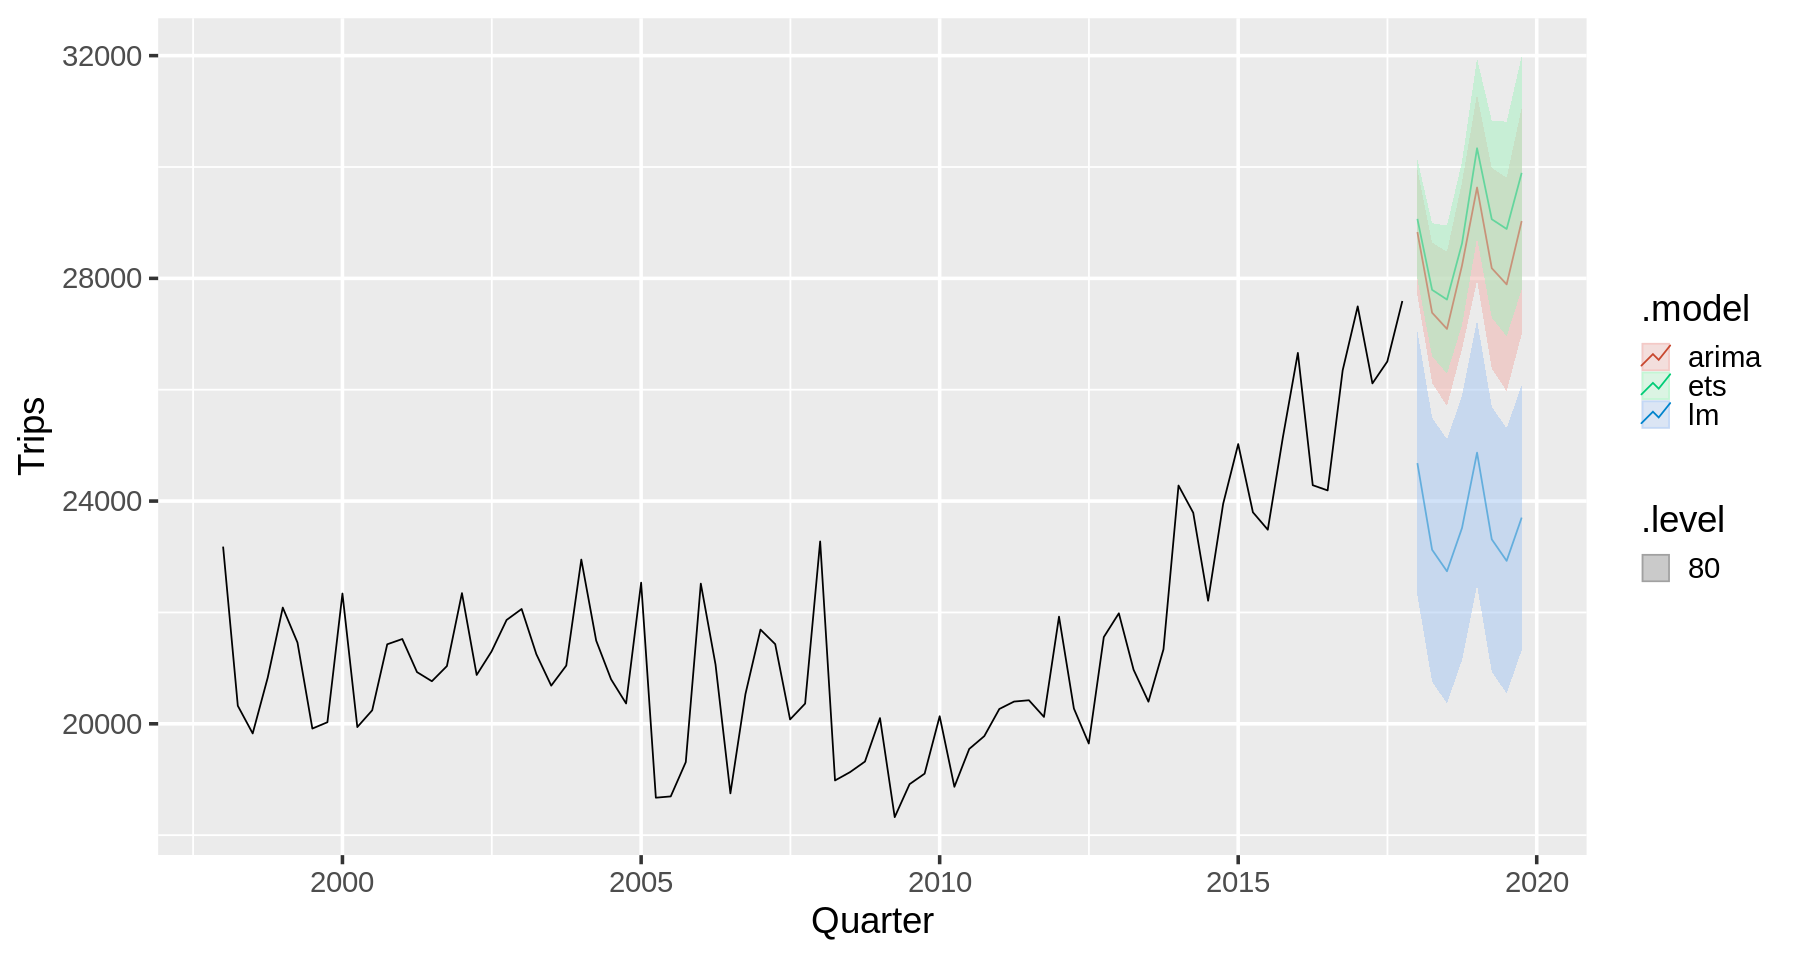

In [34]:
fit %>% 
  forecast(h = "2 years") %>% 
  autoplot(tourism_aus, level = 80, alpha = 0.5) %>%
    add_theme()

# A mable: 1 x 3
  ets          arima                    lm     
  <model>      <model>                  <model>
1 <ETS(A,A,A)> <ARIMA(0,1,1)(0,1,1)[4]> <TSLM> 


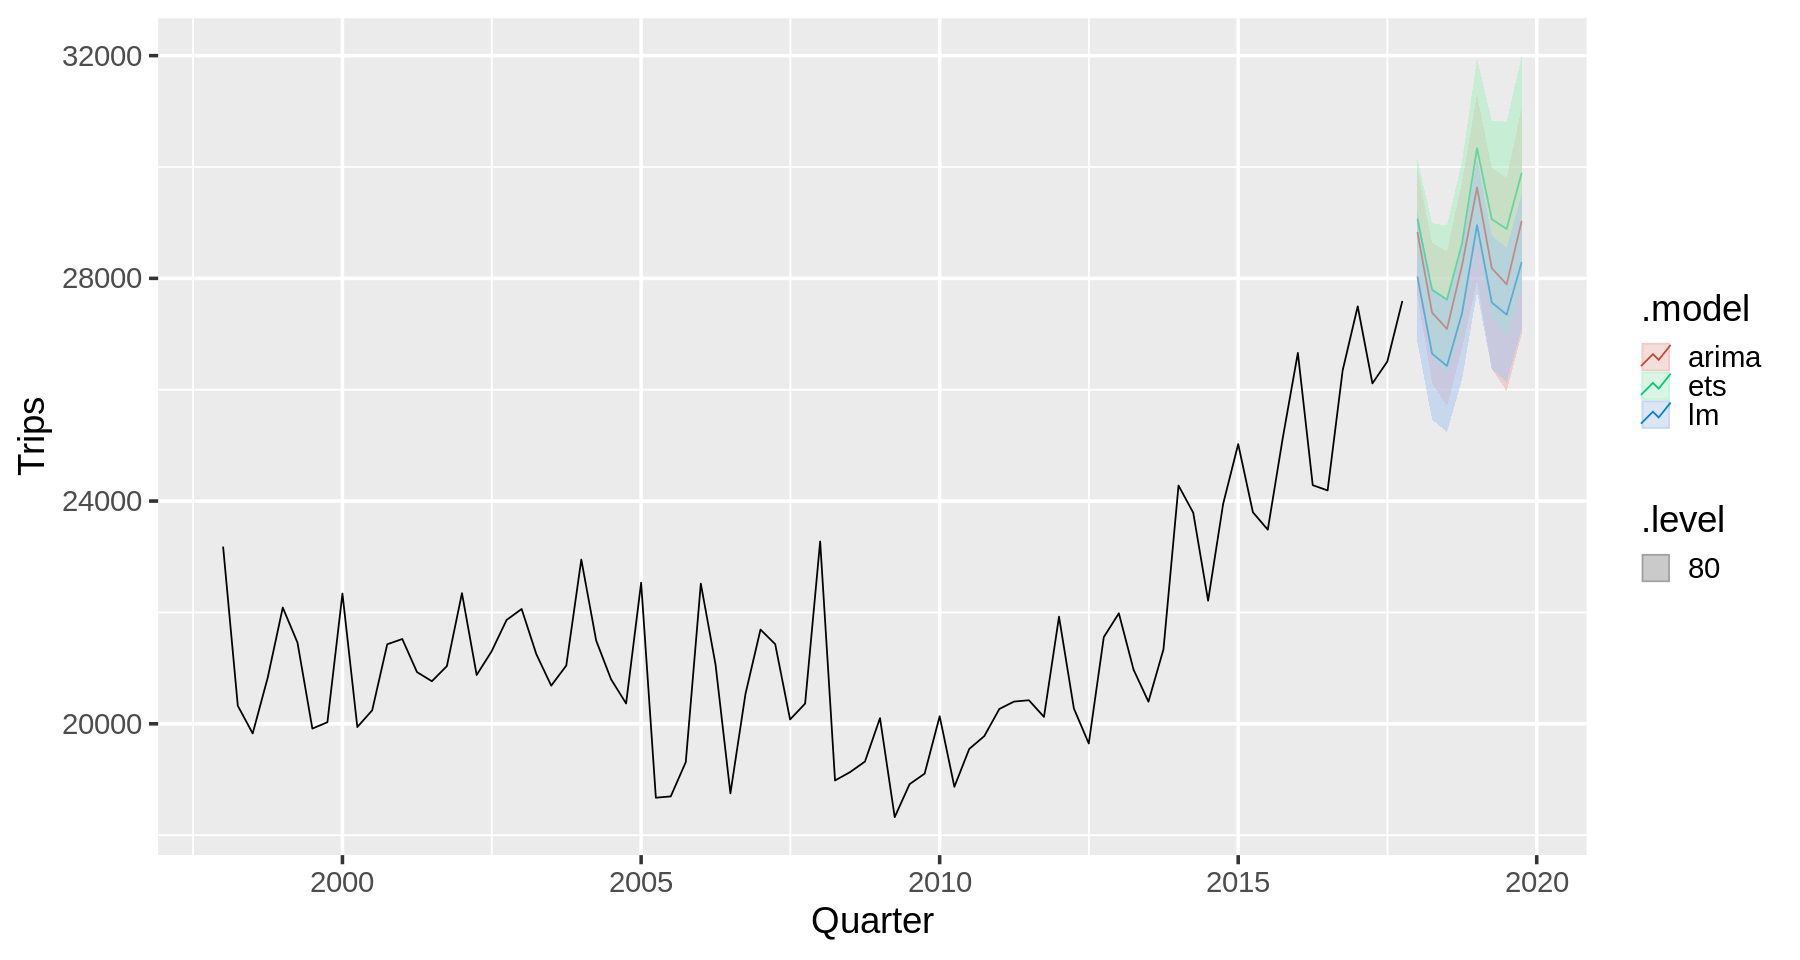

In [35]:
# improve the linear model by adding knots

(fit <- tourism_aus %>% 
  model(
    ets = ETS(Trips),
    arima = ARIMA(Trips),
    lm = TSLM(Trips ~ trend(knots = yearquarter("2010 Q1")) + season()) # what does this do? where does trend() and season() come from?
  )) %>%
    print()
fit %>% 
  forecast(h = "2 years") %>% 
  autoplot(tourism_aus, level = 80, alpha = 0.5) %>%
    add_theme()

In [37]:
# accuracy() for in sample accuracy
fit %>%
    accuracy()

.model .type    ME            RMSE     MAE      MPE        MAPE     MASE     
1 ets    Training  1.054655e+02 793.6695 604.1089  0.3787233 2.857009 0.6363847
2 arima  Training  1.535625e+02 839.5152 631.8592  0.5836375 2.972133 0.6656177
3 lm     Training -4.550804e-14 822.8874 687.9800 -0.1409391 3.231799 0.7247368
  ACF1        
1 -0.001509254
2 -0.043242597
3  0.424509942

In [38]:
# Forecast (out-of-sample) accuracy will be computed when a fable is used with accuracy()
# Note that you will need to withhold a test set to base your accuracy on.
tourism_aus %>% 
  # Withhold the last 3 years before fitting the model
  filter(Quarter < yearquarter("2015 Q1")) %>% 
  # Estimate the models on the training data (1998-2014)
  model(
    ets = ETS(Trips),
    arima = ARIMA(Trips),
    lm = TSLM(Trips ~ trend() + season())
  ) %>% 
  # Forecast the witheld time peroid (2015-2017)
  forecast(h = "3 years") %>% 
  # Compute accuracy of the forecasts relative to the actual data 
  accuracy(tourism_aus)

.model .type ME       RMSE     MAE      MPE       MAPE      MASE    
1 arima  Test  1396.660 1794.699 1452.471  5.306817  5.537458 1.584544
2 ets    Test  1894.779 2280.541 1908.836  7.228598  7.284772 2.082405
3 lm     Test  4664.145 4822.106 4664.145 18.089404 18.089404 5.088254
  ACF1     
1 0.4958699
2 0.6127302
3 0.6336985

In [39]:
# average two models for forecast due to they are both good
(fit <- tourism_aus %>% 
  model(
    ets = ETS(Trips),
    arima = ARIMA(Trips)
  ) %>% 
  mutate(
    average = (ets + arima) / 2
  )) %>%
    print()

# A mable: 1 x 3
  ets          arima                    average      
  <model>      <model>                  <model>      
1 <ETS(A,A,A)> <ARIMA(0,1,1)(0,1,1)[4]> <COMBINATION>


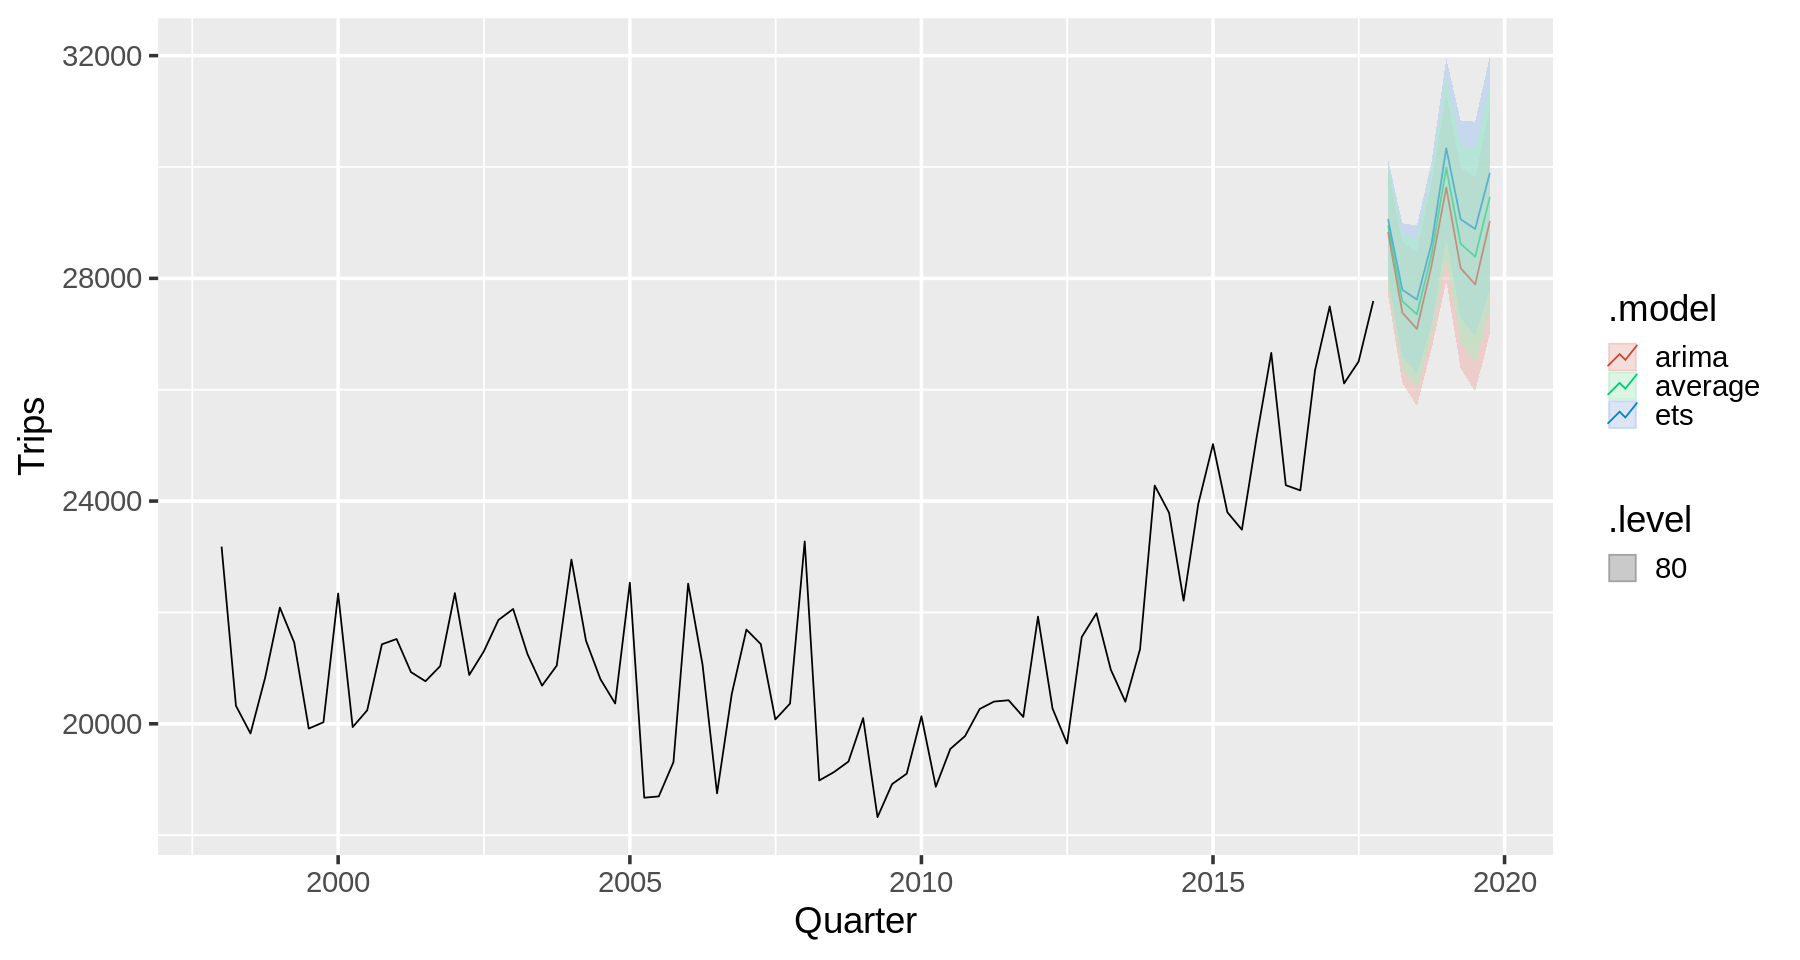

In [40]:
fit %>% 
  forecast(h = "2 years") %>% 
  autoplot(tourism_aus, level = 80, alpha = 0.5) %>%
    add_theme()

## Upscaling forecasts!

In [41]:
(tourism_state <- tourism %>% 
  group_by(State) %>% 
  summarise(Trips = sum(Trips))) %>%
    head()

State Quarter Trips   
1 ACT   1998 Q1 551.0019
2 ACT   1998 Q2 416.0256
3 ACT   1998 Q3 436.0290
4 ACT   1998 Q4 449.7984
5 ACT   1999 Q1 378.5728
6 ACT   1999 Q2 558.1781

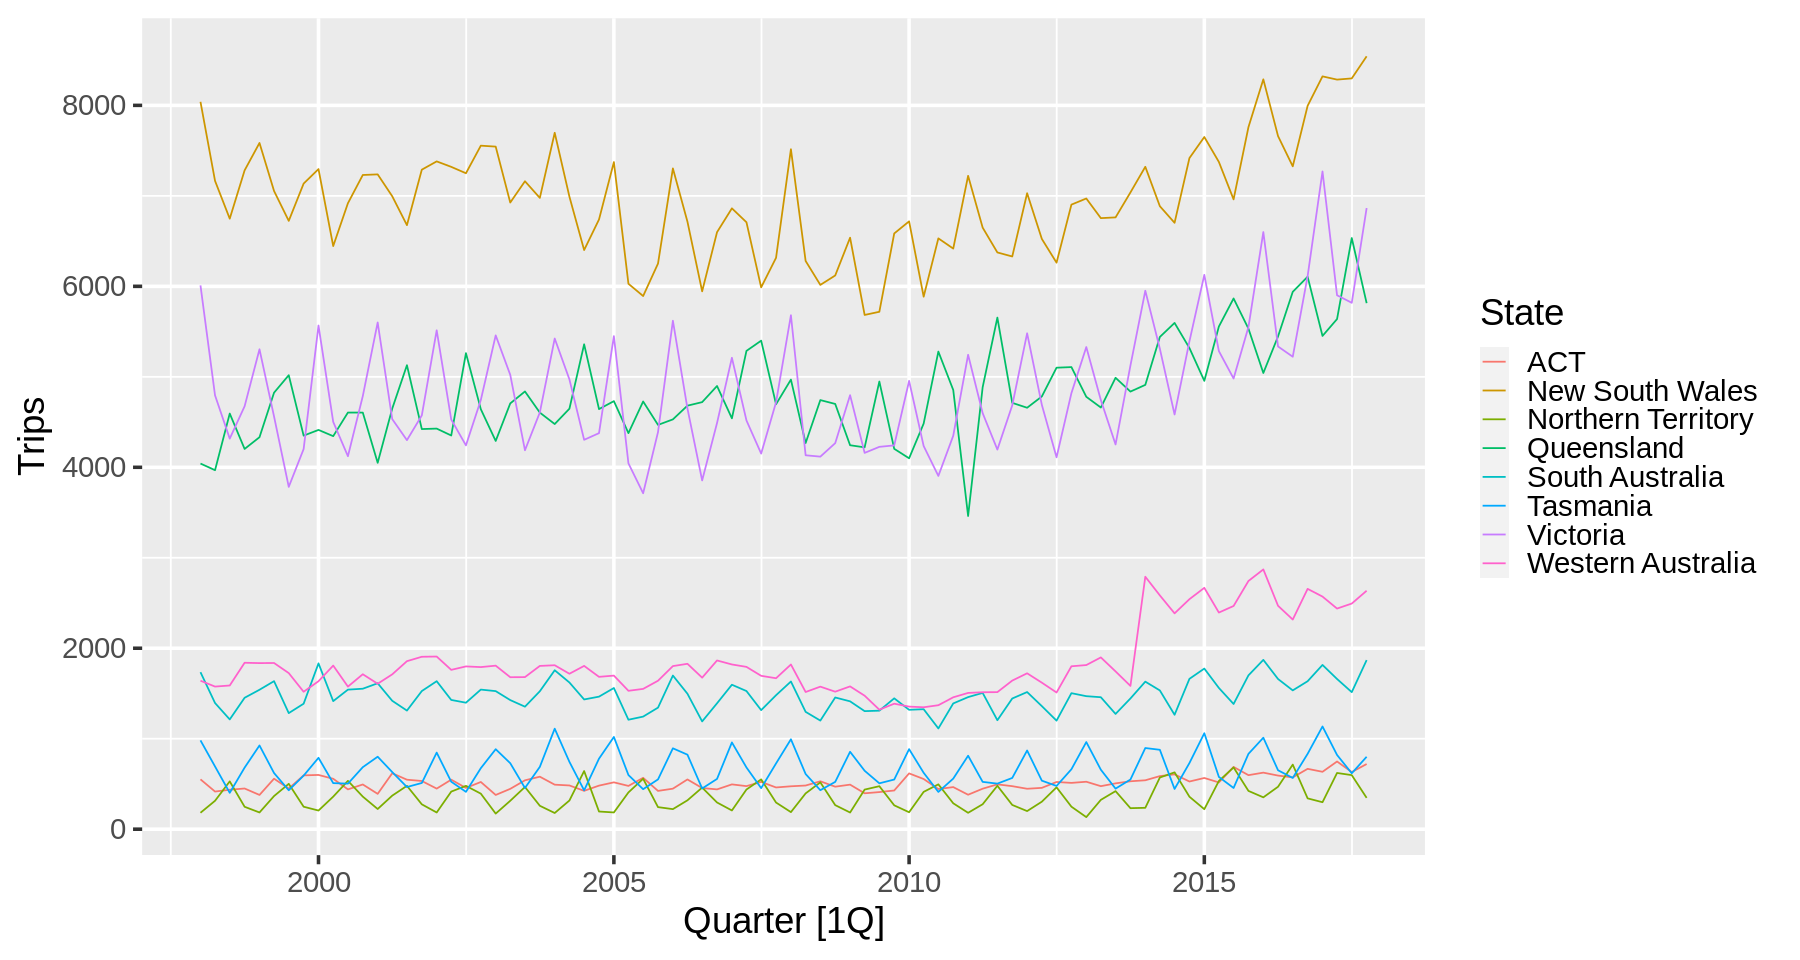

In [42]:
# 8 timeseries in total
tourism_state %>% 
  autoplot(Trips) %>%
    add_theme()

In [43]:
(fit <- tourism_state %>% 
  model(
    ets = ETS(Trips),
    arima = ARIMA(Trips)
  ) %>% 
  mutate(
    average = (ets + arima)/2
  )) %>%
    print()

# A mable: 8 x 4
# Key:     State [8]
  State              ets          arima                    average      
  <chr>              <model>      <model>                  <model>      
1 ACT                <ETS(M,A,N)> <ARIMA(0,1,1)>           <COMBINATION>
2 New South Wales    <ETS(A,N,A)> <ARIMA(0,1,1)(0,1,1)[4]> <COMBINATION>
3 Northern Territory <ETS(M,N,M)> <ARIMA(1,0,1)(0,1,1)[4]> <COMBINATION>
4 Queensland         <ETS(A,N,A)> <ARIMA(2,1,2)>           <COMBINATION>
5 South Australia    <ETS(M,N,A)> <ARIMA(1,0,1)(0,1,1)[4]> <COMBINATION>
6 Tasmania           <ETS(M,N,M)> <ARIMA(0,0,3)(2,1,0)[4]> <COMBINATION>
7 Victoria           <ETS(M,N,M)> <ARIMA(0,1,1)(0,1,1)[4]> <COMBINATION>
8 Western Australia  <ETS(M,N,M)> <ARIMA(0,1,3)>           <COMBINATION>


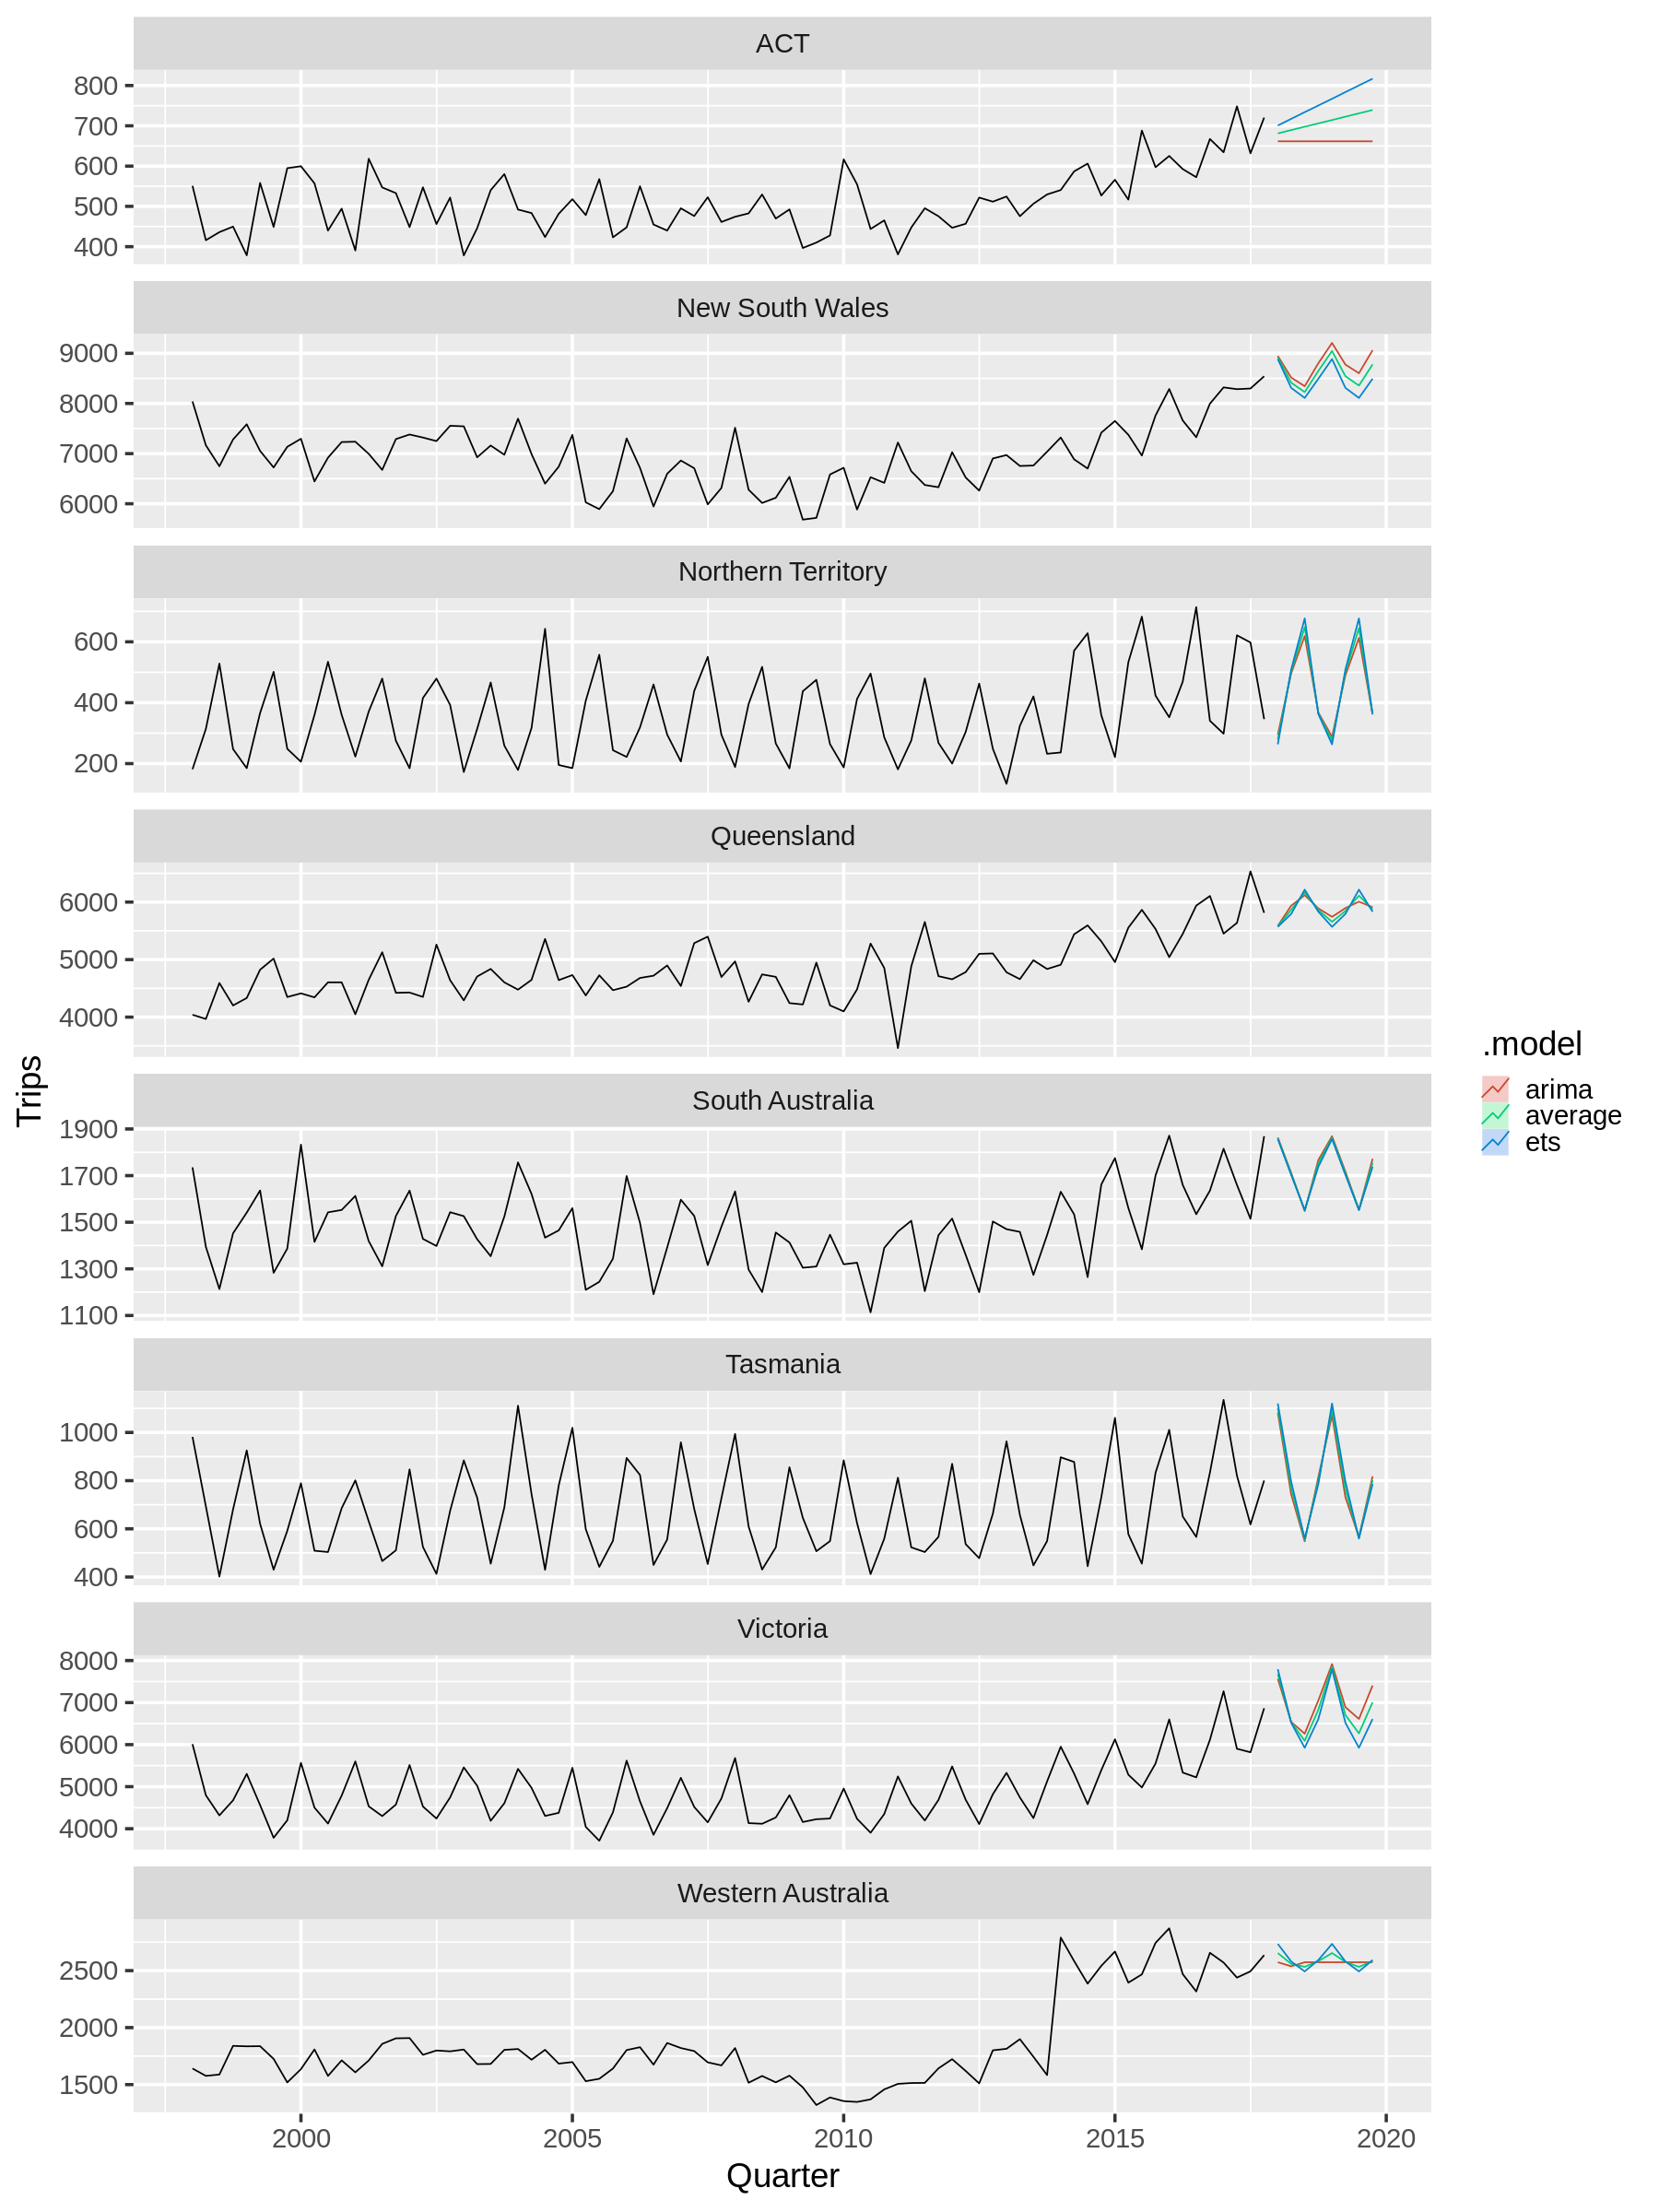

In [45]:
options(repr.plot.width = 15, repr.plot.height = 20)

fit %>% 
  forecast(h = "2 years") %>% 
  autoplot(tourism_state, level = NULL) %>%
    add_theme()

### Make 304 forecasts
Forecast per "Region", "State", "Purpose".   
**Beware: this does not have cross validation step**

In [67]:
head(tourism)

Quarter Region   State           Purpose  Trips   
1 1998 Q1 Adelaide South Australia Business 135.0777
2 1998 Q2 Adelaide South Australia Business 109.9873
3 1998 Q3 Adelaide South Australia Business 166.0347
4 1998 Q4 Adelaide South Australia Business 127.1605
5 1999 Q1 Adelaide South Australia Business 137.4485
6 1999 Q2 Adelaide South Australia Business 199.9126

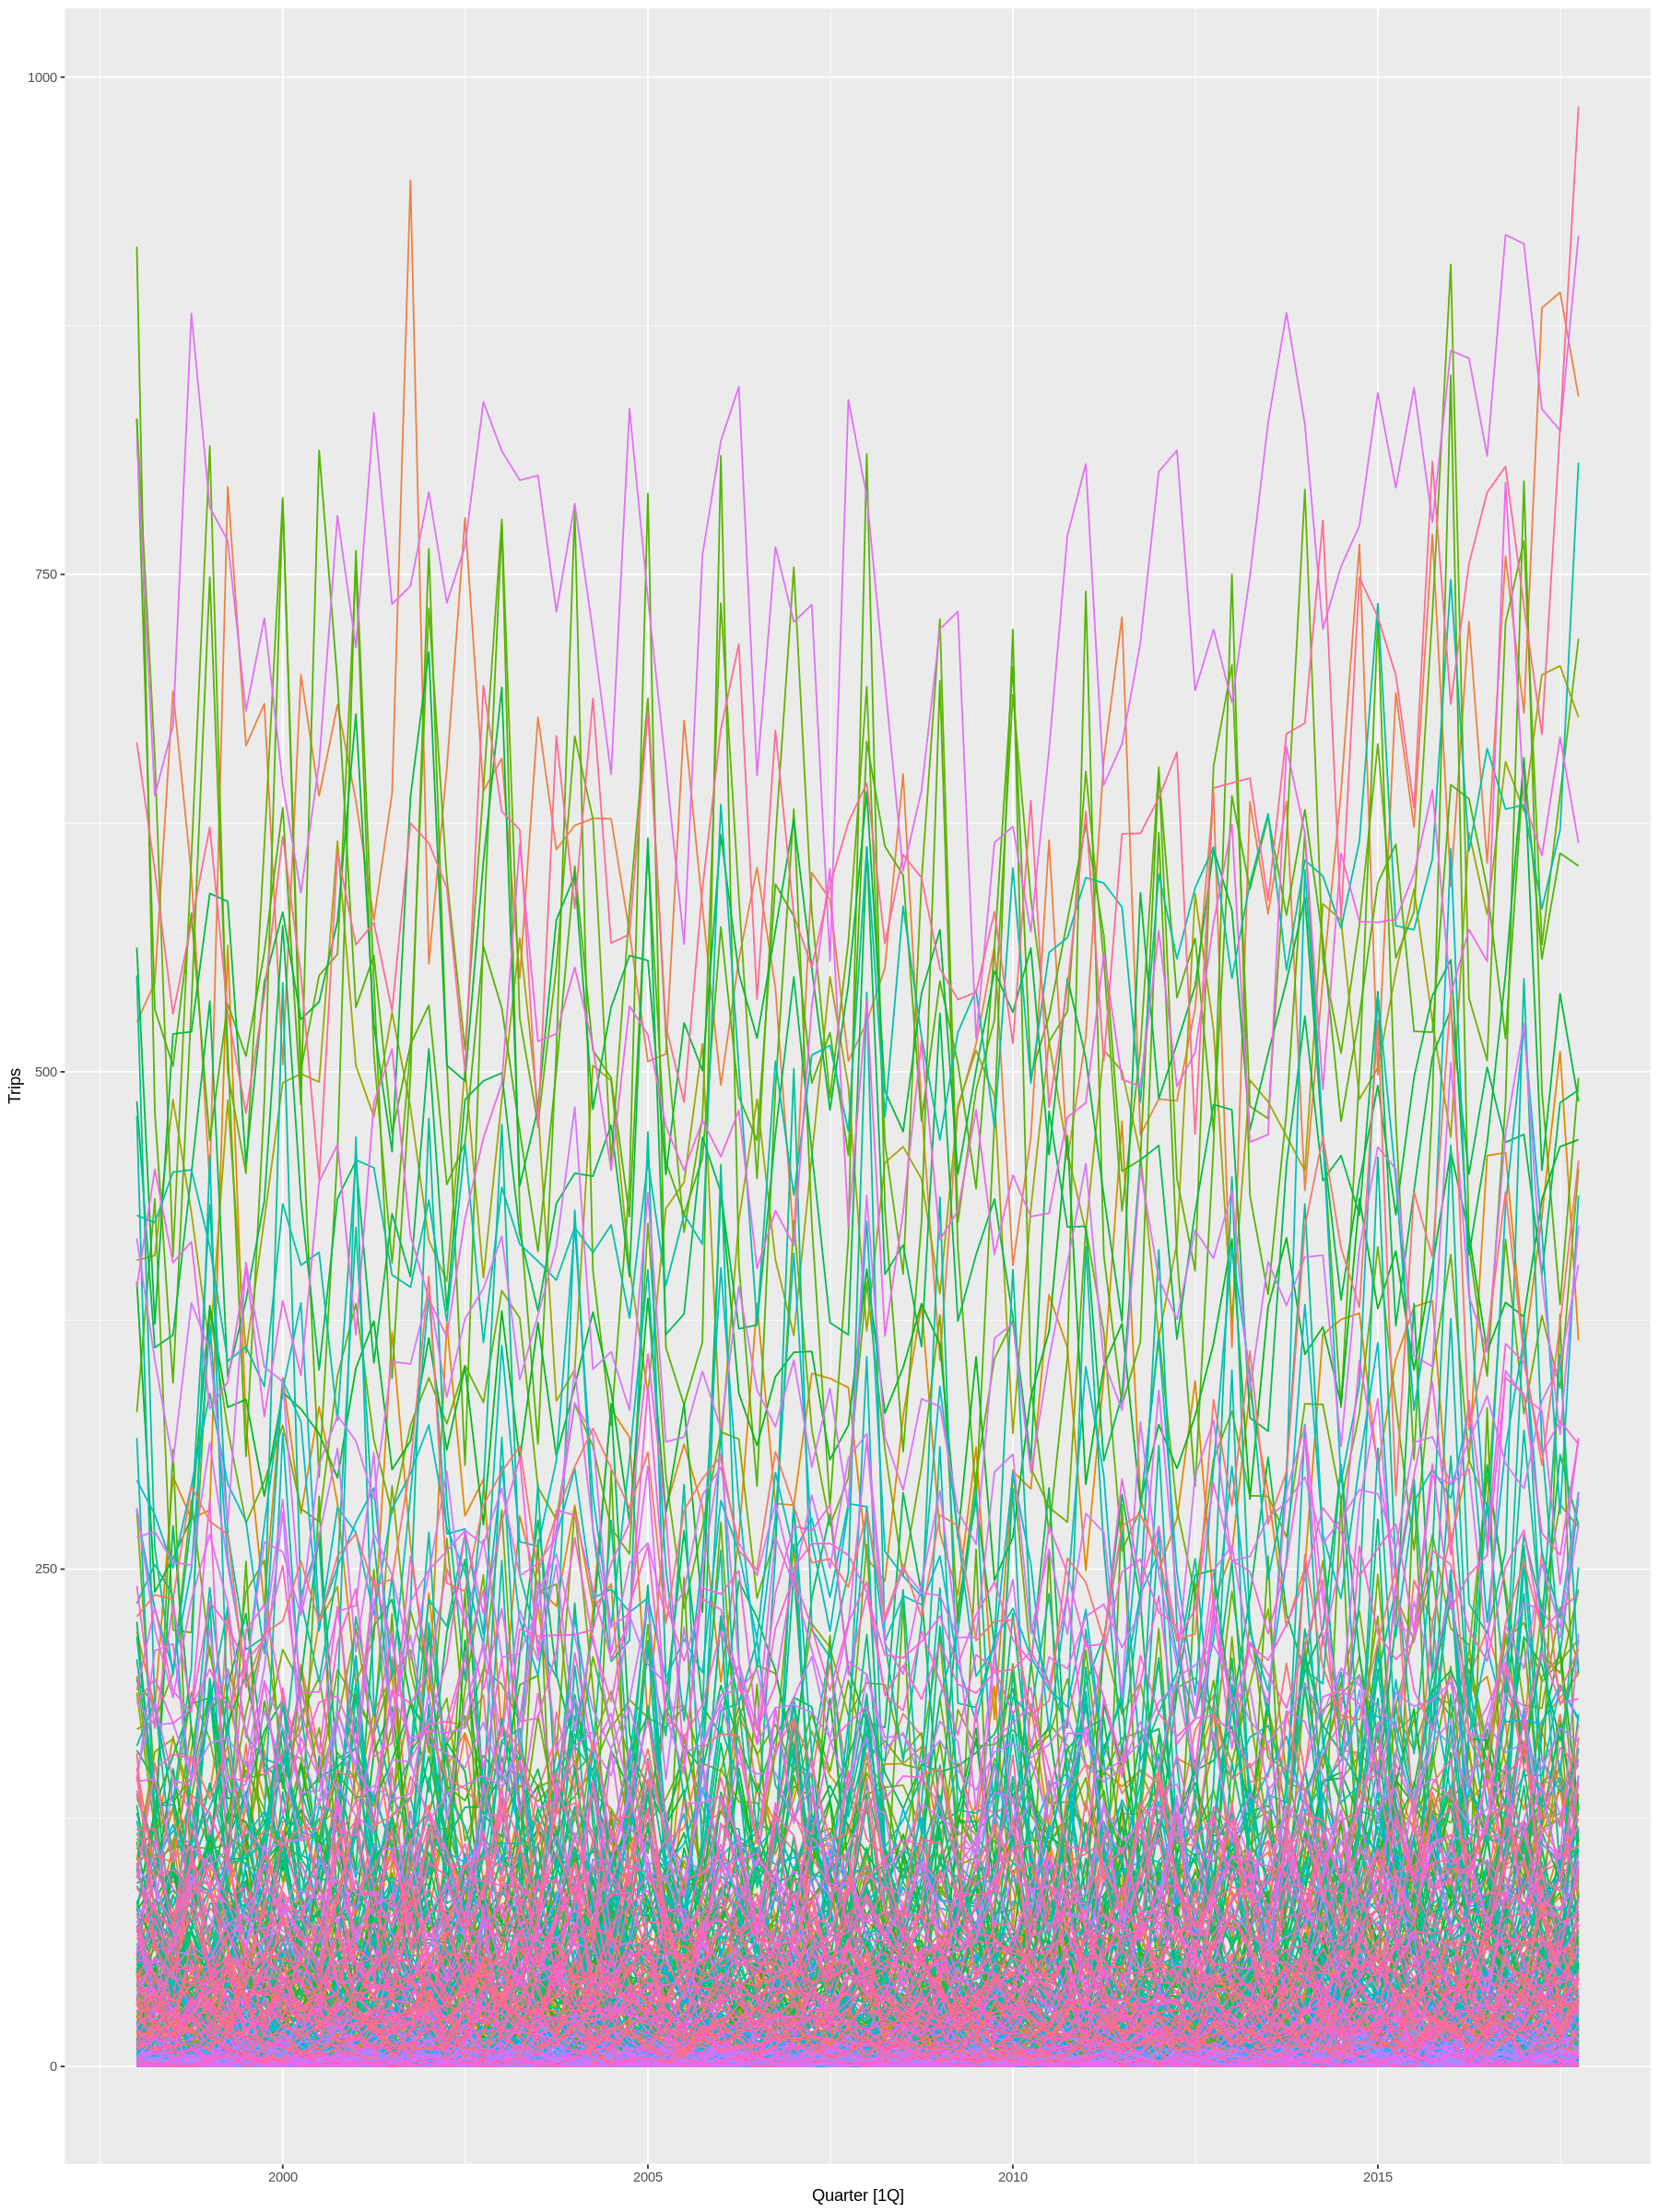

In [106]:
(tourism_large <- tourism %>% 
    as_tsibble(key = c("Region", "State", "Purpose")
               , index = 'Quarter' )) %>%
    autoplot(Trips) +
    theme(legend.position = "none")


In [78]:
# [304] time series
tourism_large %>%
    print()

# A tsibble: 24,320 x 5 [1Q]
# Key:       Region, State, Purpose [304]
   Quarter Region   State           Purpose  Trips
     <qtr> <chr>    <chr>           <chr>    <dbl>
 1 1998 Q1 Adelaide South Australia Business  135.
 2 1998 Q2 Adelaide South Australia Business  110.
 3 1998 Q3 Adelaide South Australia Business  166.
 4 1998 Q4 Adelaide South Australia Business  127.
 5 1999 Q1 Adelaide South Australia Business  137.
 6 1999 Q2 Adelaide South Australia Business  200.
 7 1999 Q3 Adelaide South Australia Business  169.
 8 1999 Q4 Adelaide South Australia Business  134.
 9 2000 Q1 Adelaide South Australia Business  154.
10 2000 Q2 Adelaide South Australia Business  169.
# … with 24,310 more rows


In [84]:
# model fit

(fit <- tourism_large %>% 
  model(
    ets = ETS(Trips),
    arima = ARIMA(Trips)
  ) %>% 
  mutate(
    average = (ets + arima)/2
  )) %>%
    print()

Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


# A mable: 304 x 6
# Key:     Region, State, Purpose [304]
   Region      State         Purpose  ets       arima                 average   
   <chr>       <chr>         <chr>    <model>   <model>               <model>   
 1 Adelaide    South Austra… Business <ETS(M,N… <ARIMA(0,0,0)(1,0,1)… <COMBINAT…
 2 Adelaide    South Austra… Holiday  <ETS(A,N… <ARIMA(0,0,0)(1,0,1)… <COMBINAT…
 3 Adelaide    South Austra… Other    <ETS(M,A… <ARIMA(0,1,1) w/ dri… <COMBINAT…
 4 Adelaide    South Austra… Visiting <ETS(A,N… <ARIMA(0,0,0)(1,0,1)… <COMBINAT…
 5 Adelaide H… South Austra… Business <ETS(A,N… <ARIMA(0,0,0) w/ mea… <COMBINAT…
 6 Adelaide H… South Austra… Holiday  <ETS(A,A… <ARIMA(0,1,1)>        <COMBINAT…
 7 Adelaide H… South Austra… Other    <ETS(A,N… <ARIMA(0,1,2)(0,0,2)… <COMBINAT…
 8 Adelaide H… South Austra… Visiting <ETS(M,A… <ARIMA(0,1,1)>        <COMBINAT…
 9 Alice Spri… Northern Ter… Business <ETS(M,N… <ARIMA(0,1,1)(0,0,1)… <COMBINAT…
10 Alice Spri… Northern Ter… Holiday  <ETS(M,N… <A

In [89]:
# make the 304 forecast

(fc <- fit %>% 
  forecast(h = "2 years")) %>%
    head(10)

### visualization fails however....
#%>% 
 # autoplot(tourism_large, level = NULL) +
 #   theme(legend.position = "none")

Region   State           Purpose  .model Quarter Trips    .distribution
1  Adelaide South Australia Business ets    2018 Q1 148.5239 N(149, 1022) 
2  Adelaide South Australia Business ets    2018 Q2 172.6744 N(173, 1406) 
3  Adelaide South Australia Business ets    2018 Q3 184.1910 N(184, 1627) 
4  Adelaide South Australia Business ets    2018 Q4 171.2983 N(171, 1431) 
5  Adelaide South Australia Business ets    2019 Q1 148.5239 N(149, 1094) 
6  Adelaide South Australia Business ets    2019 Q2 172.6746 N(173, 1503) 
7  Adelaide South Australia Business ets    2019 Q3 184.1911 N(184, 1738) 
8  Adelaide South Australia Business ets    2019 Q4 171.2984 N(171, 1527) 
9  Adelaide South Australia Holiday  ets    2018 Q1 210.3415 N(210, 457)  
10 Adelaide South Australia Holiday  ets    2018 Q2 173.1889 N(173, 473)

In [90]:
class(fc)

[1] "fbl_ts"     "tbl_ts"     "tbl_df"     "tbl"        "data.frame"

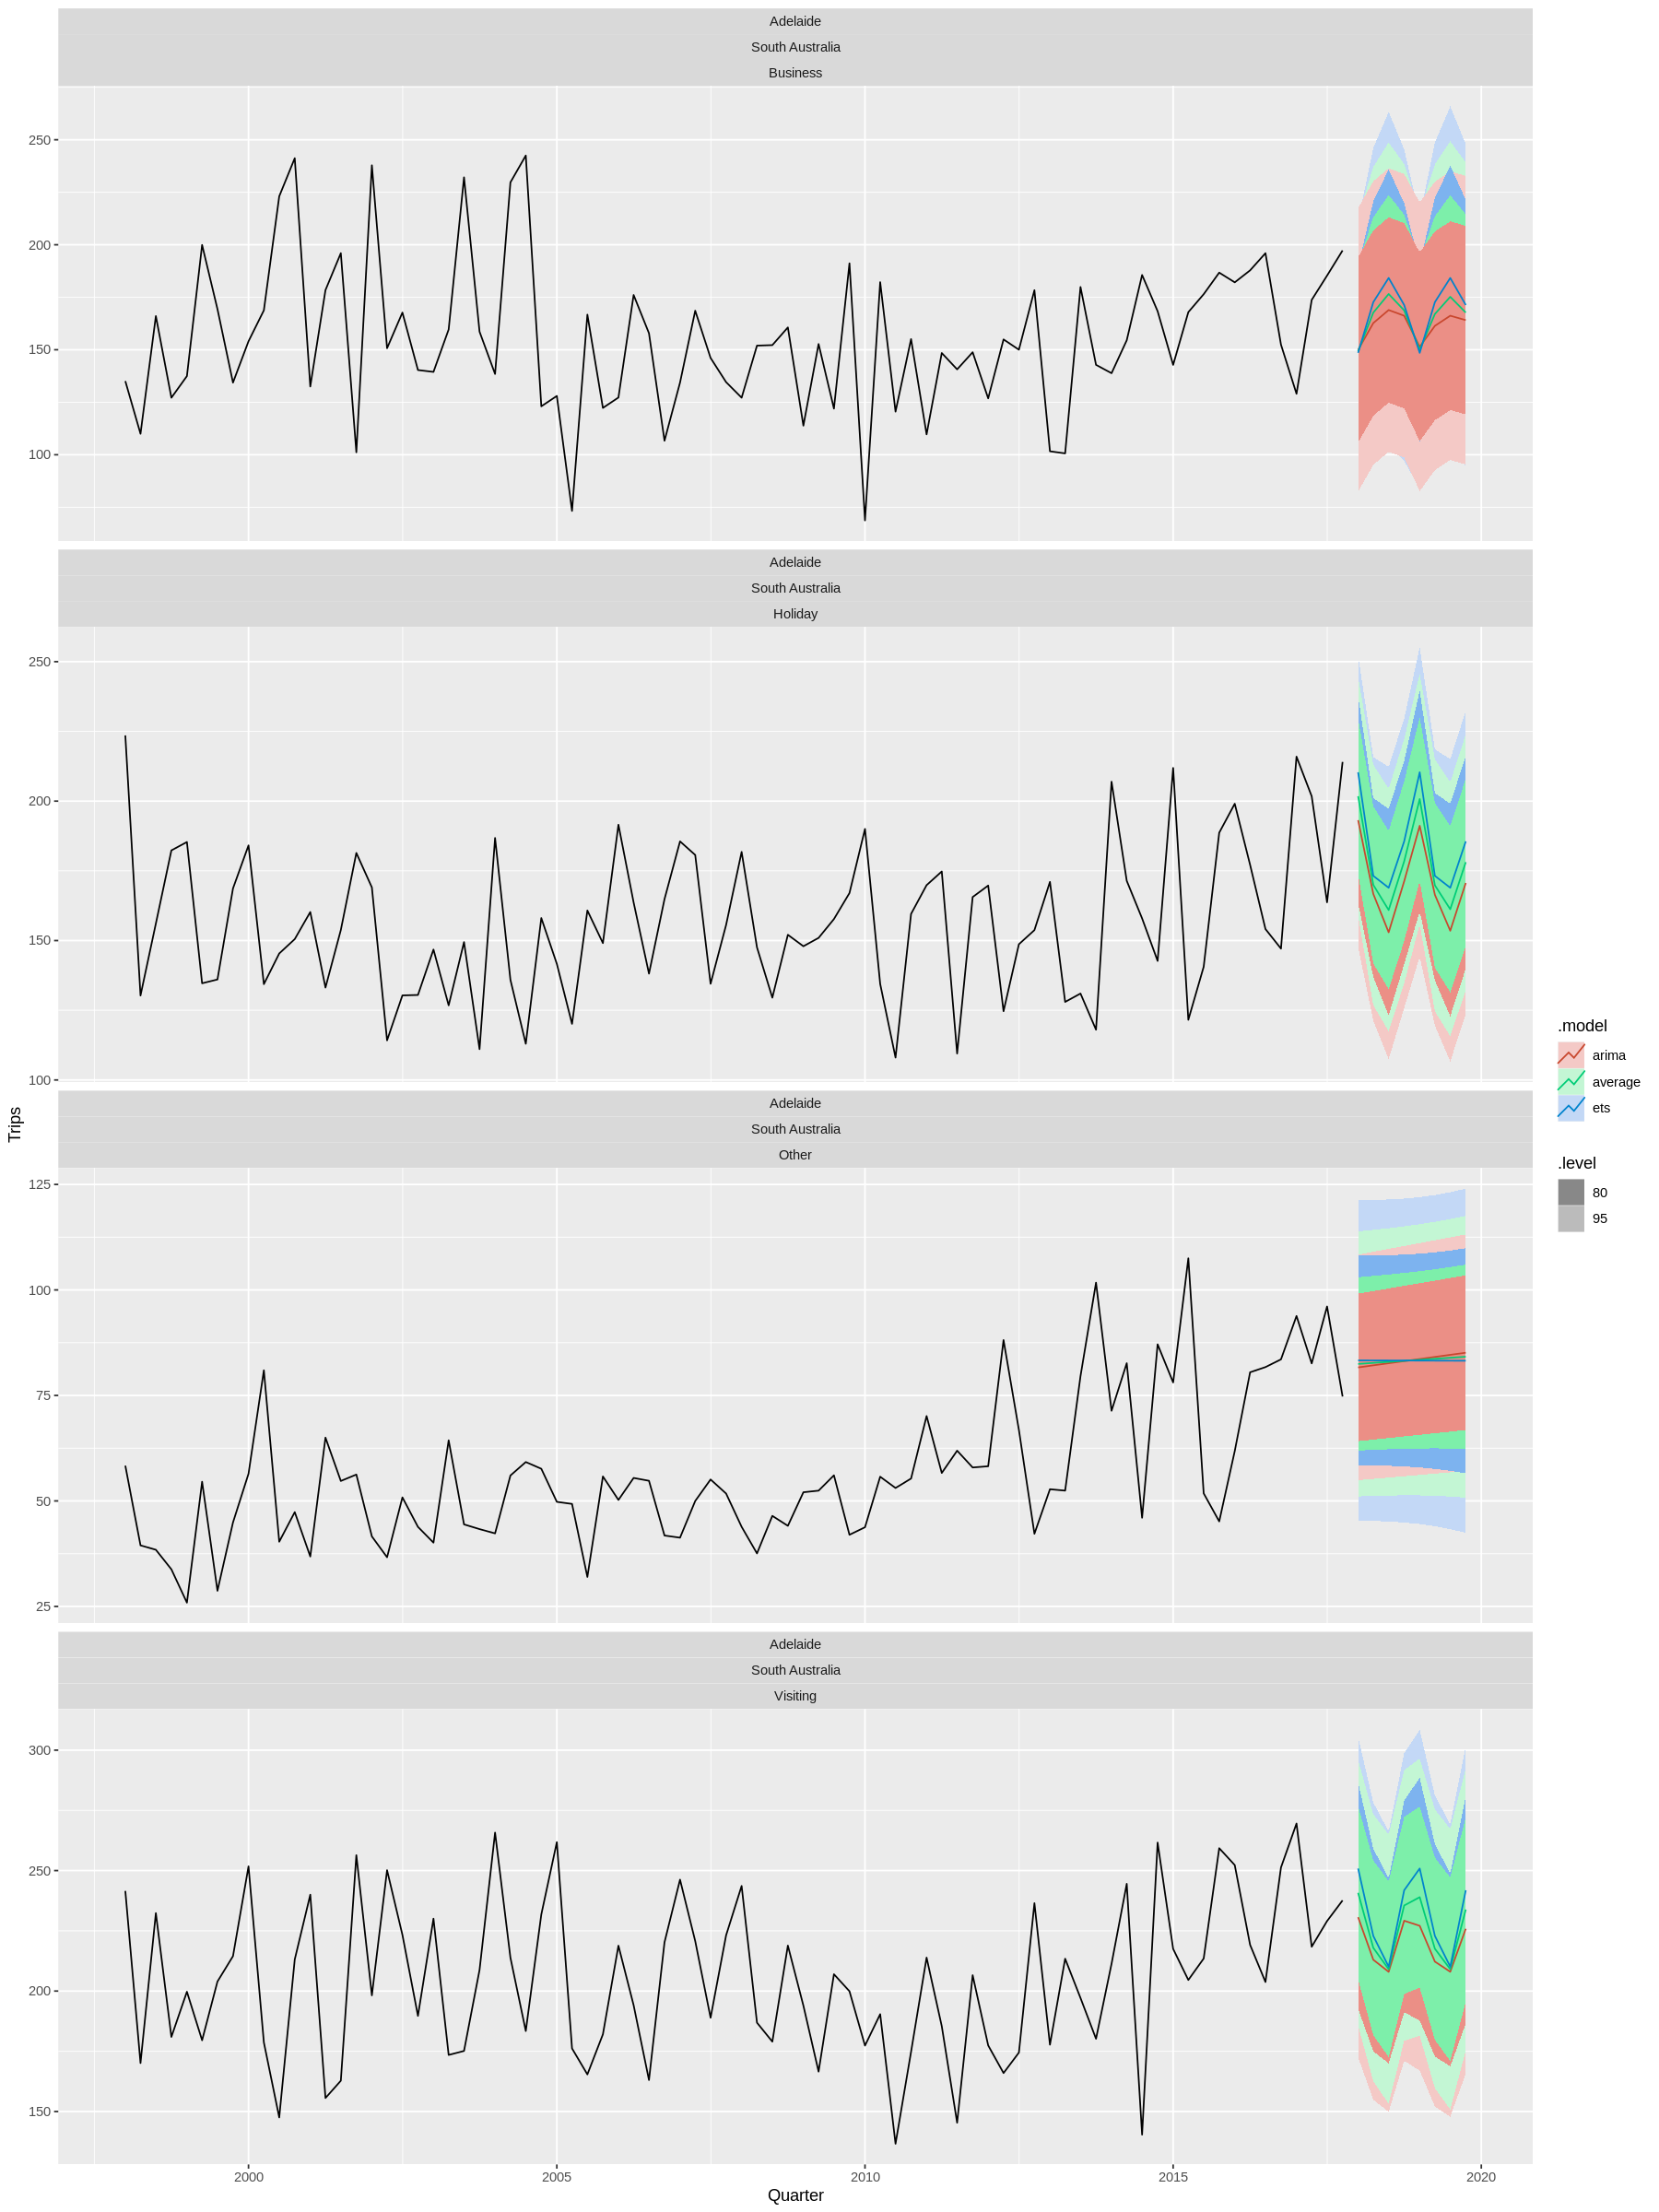

In [105]:
# partial check
fc %>%
    filter(Region=='Adelaide')%>%
    autoplot(tourism_large) 